In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
meta = pd.read_csv("metadata.csv")
gps = pd.read_excel("77FEB2020.XLSX")

In [13]:
roads = gps["MAIN_CROSS_STREET"].str.split(" + ", regex=False)

In [18]:
road_arr = []

for road in roads:
	road_arr.extend(road)

In [20]:
road_series = pd.Series(road_arr)

In [31]:
unique_roads = road_series.unique()

In [37]:
matches_regex = "|".join(unique_roads)

matches_bools = meta["Intersection"].str.contains(matches_regex, na=False, regex=True)

C:\Users\megam\AppData\Local\Temp/ipykernel_492/3230190839.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  matches_bools = meta["Intersection"].str.contains(matches_regex, na=False, regex=True)


In [38]:
matched_rows = meta[matches_bools]

matched_rows contains all segment IDs and intersections that are relevant to the route analyzed. Now create a new daily traffic score that contains only these segments

In [42]:
traffic = pd.read_csv("data_1.csv")

In [45]:
relevant_traffic = traffic.merge(matched_rows, on="Segment ID")

In [47]:
traffic = relevant_traffic

In [48]:
traffic["Score"] = traffic["Speed(miles/hour)"] / traffic["Ref Speed(miles/hour)"]
traffic["Date Time"] = pd.to_datetime(traffic["Date Time"]).dt.tz_localize(None)
traffic["Date"] = traffic["Date Time"].dt.date
traffic["Time"] = traffic["Date Time"].dt.time

In [49]:
kwh = pd.read_csv("block_weather_avg_test.csv",index_col=0)
kwh["Date Time"] = pd.to_datetime(kwh["Date"]).dt.tz_localize(None)
kwh["Date"] = kwh["Date Time"].dt.date
kwh_by_date = kwh.groupby("Date").agg({"kwh": "mean"})

In [50]:
confident_traffic = traffic.loc[traffic["CValue"] > 0.9]
mean_scores = confident_traffic.groupby(["Date", "Segment ID"])["Score"].apply(np.mean).reset_index()
day_scores = mean_scores.groupby("Date").agg({"Score": "mean"})
merged = pd.merge(kwh_by_date, day_scores, on="Date")

<AxesSubplot:xlabel='Score', ylabel='kwh'>

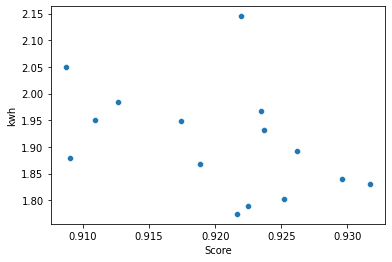

In [51]:
sns.scatterplot(merged, x="Score", y="kwh")